In [ ]:
%run /Desktop/Share/CUDA_DEVICE_setup.py -n 1

In [ ]:
import os
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = "1"  # set as the using GPU ID

# QAT on Custom Dataset for Garbage Classification

In this notebook, we will create a custom dataset for garbage classification using images from 12 classes. We will use Brevitas for quantization-aware for training.

In [3]:
#!kaggle datasets download "mostafaabla/garbage-classification"

Dataset URL: https://www.kaggle.com/datasets/mostafaabla/garbage-classification
License(s): ODbL-1.0
 94% 224M/239M [00:01<00:00, 128MB/s]
100% 239M/239M [00:02<00:00, 124MB/s]


In [4]:
#!unzip garbage-classification.zip

串流輸出內容已截斷至最後 5000 行。
  inflating: garbage_classification/paper/paper381.jpg  
  inflating: garbage_classification/paper/paper382.jpg  
  inflating: garbage_classification/paper/paper383.jpg  
  inflating: garbage_classification/paper/paper384.jpg  
  inflating: garbage_classification/paper/paper385.jpg  
  inflating: garbage_classification/paper/paper386.jpg  
  inflating: garbage_classification/paper/paper387.jpg  
  inflating: garbage_classification/paper/paper388.jpg  
  inflating: garbage_classification/paper/paper389.jpg  
  inflating: garbage_classification/paper/paper39.jpg  
  inflating: garbage_classification/paper/paper390.jpg  
  inflating: garbage_classification/paper/paper391.jpg  
  inflating: garbage_classification/paper/paper392.jpg  
  inflating: garbage_classification/paper/paper393.jpg  
  inflating: garbage_classification/paper/paper394.jpg  
  inflating: garbage_classification/paper/paper395.jpg  
  inflating: garbage_classification/paper/paper396.jpg  
  inflating

Check files under the current working directory.

In [5]:
#!pip install torchinfo

In [6]:
# Import necessary libraries
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
import torchvision
import torchinfo

In [7]:
class CustomImageDataset(Dataset):
    def __init__(self, root_dir, classes, transform=None):
        """
        Initialize the dataset with the directory containing images, class names, and transformations.

        Parameters:
        root_dir (str): Directory with all the images.
        classes (list): List of class names.
        transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.classes = classes
        self.transform = transform
        self.image_paths, self.labels = self._load_images_and_labels()

    def _load_images_and_labels(self):
        """
        Load images and their corresponding labels from the directory.

        Returns:
        image_paths (list): List of image file paths.
        labels (list): List of labels corresponding to the images.
        """
        image_paths = []
        labels = []
        for label, classname in enumerate(self.classes):
            class_dir = os.path.join(self.root_dir, classname)
            for img_name in os.listdir(class_dir):
                if img_name.endswith(('.png', '.jpg', '.jpeg')):
                    image_paths.append(os.path.join(class_dir, img_name))
                    labels.append(label)
        return image_paths, labels

    def __len__(self):
        """
        Return the total number of samples.
        """
        return len(self.image_paths)

    def __getitem__(self, idx):
        """
        Get a sample from the dataset at the given index.

        Parameters:
        idx (int): Index of the sample.

        Returns:
        image (Tensor): Transformed image.
        label (int): Label of the image.
        """
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [8]:
# Define the data transformations
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize images to 32x32
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize images
])

In [9]:
# Define the classes
classes = ['battery', 'biological', 'brown-glass', 'cardboard', 'clothes',
           'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']

# Define the root directory where images are stored
root_dir = 'garbage_classification/'

# Create the custom dataset
custom_dataset = CustomImageDataset(root_dir=root_dir, classes=classes, transform=transform)

# Split the dataset into training (80%) and test (20%) sets
train_size = int(0.8 * len(custom_dataset))
test_size = len(custom_dataset) - train_size
train_dataset, test_dataset = random_split(custom_dataset, [train_size, test_size])

In [12]:
# Create data loaders
train_batch_size = 32
test_batch_size = 4

trainloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False, num_workers=2)

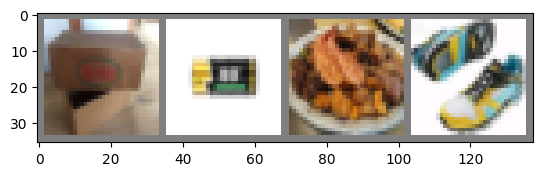

cardboard battery biological shoes


In [13]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(testloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(test_batch_size)))

2. Define a Convolutional Neural Network
========================================

Copy the neural network from the Neural Networks section before and
modify it to take 3-channel images (instead of 1-channel images as it
was defined).


In [14]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cpu


In [15]:
num_class = len(classes)

In [16]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


# Define the neural network by inheriting from nn.Module
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # Define the first convolutional layer
        # - in_channels: Number of input channels (3 for RGB images)
        # - out_channels: Number of output channels (6 filters)
        # - kernel_size: Size of the convolutional kernel (5x5)
        self.conv1 = nn.Conv2d(3, 6, 5)

        # Define a max-pooling layer
        # - kernel_size: Size of the pooling window (2x2)
        # - stride: Step size for the window (2)
        self.pool = nn.MaxPool2d(2, 2)

        # Define the second convolutional layer
        # - in_channels: Number of input channels (6 from previous conv layer)
        # - out_channels: Number of output channels (16 filters)
        # - kernel_size: Size of the convolutional kernel (5x5)
        self.conv2 = nn.Conv2d(6, 16, 5)

        # Define the first fully connected layer
        # - in_features: Number of input features (16 * 5 * 5 from previous layers)
        # - out_features: Number of output features (120)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)

        # Define the second fully connected layer
        # - in_features: Number of input features (120)
        # - out_features: Number of output features (84)
        self.fc2 = nn.Linear(120, 84)

        # Define the third fully connected layer
        # - in_features: Number of input features (84)
        # - out_features: Number of output features (10, for 10 classes)
        # self.fc3 = nn.Linear(84, 10)
        self.fc3 = nn.Linear(84, num_class)

    # Define the forward pass
    def forward(self, x):
        # Apply the first convolutional layer followed by ReLU activation and max-pooling
        x = self.pool(F.relu(self.conv1(x)))

        # Apply the second convolutional layer followed by ReLU activation and max-pooling
        x = self.pool(F.relu(self.conv2(x)))

        # Flatten the tensor, keeping the batch dimension
        x = torch.flatten(x, 1)

        # Apply the first fully connected layer followed by ReLU activation
        x = F.relu(self.fc1(x))

        # Apply the second fully connected layer followed by ReLU activation
        x = F.relu(self.fc2(x))

        # Apply the third fully connected layer to produce the final output
        x = self.fc3(x)

        return x

# Create an instance of the neural network and move it to the specified device (CPU or GPU)
net = Net().to(device)

print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=12, bias=True)
)


In [17]:
torchinfo.summary(net, (1, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [1, 12]                   --
├─Conv2d: 1-1                            [1, 6, 28, 28]            456
├─MaxPool2d: 1-2                         [1, 6, 14, 14]            --
├─Conv2d: 1-3                            [1, 16, 10, 10]           2,416
├─MaxPool2d: 1-4                         [1, 16, 5, 5]             --
├─Linear: 1-5                            [1, 120]                  48,120
├─Linear: 1-6                            [1, 84]                   10,164
├─Linear: 1-7                            [1, 12]                   1,020
Total params: 62,176
Trainable params: 62,176
Non-trainable params: 0
Total mult-adds (M): 0.66
Input size (MB): 0.01
Forward/backward pass size (MB): 0.05
Params size (MB): 0.25
Estimated Total Size (MB): 0.31

4. Train the network
====================

This is when things start to get interesting. We simply have to loop
over our data iterator, and feed the inputs to the network and optimize.


In [18]:
# Define function to calculate accuracy
def calculate_accuracy(loader, model):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

In [19]:
def calculate_loss(loader, model, criterion):
    total_loss = 0.0
    with torch.no_grad():
        for data in loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
    return total_loss / len(loader)

In [20]:
def train_model(model, train_loader, test_loader, num_epochs=10):
    # Define the loss function and the optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    train_accuracies = []
    train_losses = []
    test_accuracies = []
    test_losses = []

    print("Start Training:")
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0.0  # Initialize the running loss for each epoch
        correct = 0
        total = 0

        model.train()  # Set the network to training mode

        for data in train_loader:
            # Get the inputs and labels from the data loader
            inputs, labels = data

            # Move the inputs and labels to the specified device (CPU or GPU)
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Zero the parameter gradients to avoid accumulation from previous iterations
            optimizer.zero_grad()

            # Perform the forward pass: compute the network's outputs
            outputs = model(inputs)

            # Compute the loss using the criterion
            loss = criterion(outputs, labels)

            # Perform the backward pass: compute the gradients
            loss.backward()

            # Update the network parameters using the optimizer
            optimizer.step()

            # Accumulate the loss for the current mini-batch
            running_loss += loss.item()

            # Calculate training accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_accuracy = 100 * correct / total
        train_loss = running_loss / len(train_loader)
        train_accuracies.append(train_accuracy)
        train_losses.append(train_loss)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%')

        # Evaluate on the test set
        model.eval()  # Set the network to evaluation mode
        test_accuracy = calculate_accuracy(test_loader, model)
        test_loss = calculate_loss(test_loader, model, criterion)
        test_accuracies.append(test_accuracy)
        test_losses.append(test_loss)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

    print('Finished Training')
    return train_accuracies, train_losses, test_accuracies, test_losses

In [21]:
# Call the training function
train_accs, train_losses, test_accs, test_losses = train_model(net, trainloader, testloader, num_epochs=10)

Start Training:
Epoch [1/10], Loss: 2.2877, Training Accuracy: 31.35%
Epoch [1/10], Test Loss: 2.0868, Test Accuracy: 34.42%
Epoch [2/10], Loss: 1.9948, Training Accuracy: 34.89%
Epoch [2/10], Test Loss: 1.9181, Test Accuracy: 38.87%
Epoch [3/10], Loss: 1.8124, Training Accuracy: 41.43%
Epoch [3/10], Test Loss: 1.7624, Test Accuracy: 42.18%
Epoch [4/10], Loss: 1.6967, Training Accuracy: 44.25%
Epoch [4/10], Test Loss: 1.6697, Test Accuracy: 44.80%
Epoch [5/10], Loss: 1.6166, Training Accuracy: 46.57%
Epoch [5/10], Test Loss: 1.6006, Test Accuracy: 47.12%
Epoch [6/10], Loss: 1.5451, Training Accuracy: 48.68%
Epoch [6/10], Test Loss: 1.5318, Test Accuracy: 48.34%
Epoch [7/10], Loss: 1.4682, Training Accuracy: 50.89%
Epoch [7/10], Test Loss: 1.4404, Test Accuracy: 52.43%
Epoch [8/10], Loss: 1.3608, Training Accuracy: 54.61%
Epoch [8/10], Test Loss: 1.3121, Test Accuracy: 57.40%
Epoch [9/10], Loss: 1.2855, Training Accuracy: 56.90%
Epoch [9/10], Test Loss: 1.2659, Test Accuracy: 58.78%
Epo

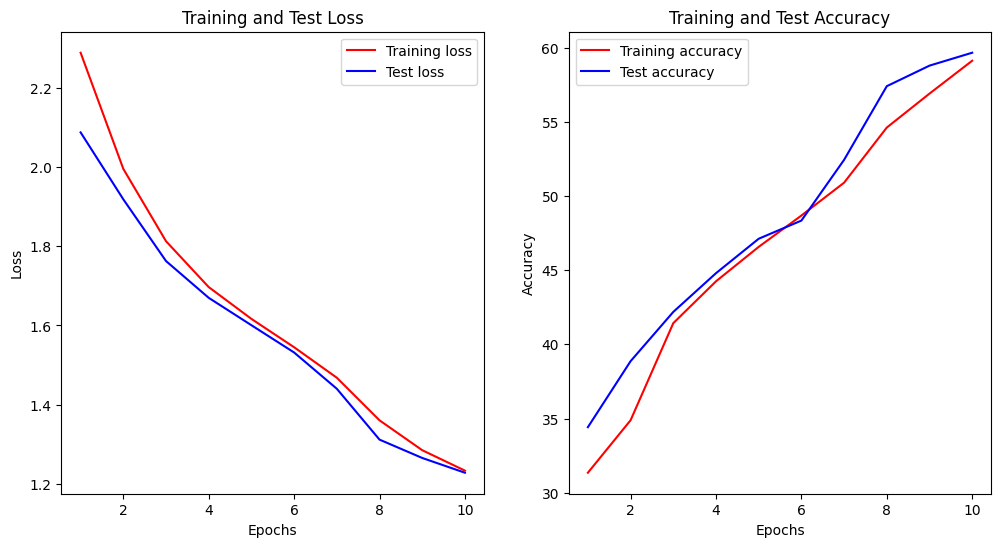

In [22]:
epoch_num = range(1, len(train_accs)+1)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_num, train_losses, 'r', label='Training loss')
plt.plot(epoch_num, test_losses, 'b', label='Test loss')
plt.title('Training and Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epoch_num, train_accs, 'r', label='Training accuracy')
plt.plot(epoch_num, test_accs, 'b', label='Test accuracy')
plt.title('Training and Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Brevitas

In [23]:
!pip install brevitas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 626.6/626.6 kB 3.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [24]:
import brevitas.nn as qnn

class QuantWeightActBiasNet(nn.Module):
    def __init__(self):
        super(QuantWeightActBiasNet, self).__init__()
        self.quant_inp = qnn.QuantIdentity(bit_width=8)
        self.conv1 = qnn.QuantConv2d(3, 6, 5, bias=True, weight_bit_width=8 )
        self.relu1 = qnn.QuantReLU(bit_width=8 )
        self.conv2 = qnn.QuantConv2d(6, 16, 5, bias=True, weight_bit_width=8  )
        self.relu2 = qnn.QuantReLU(bit_width=8 )
        self.fc1 = qnn.QuantLinear(16 * 5 * 5, 120, bias=True, weight_bit_width=8  )
        self.relu3 = qnn.QuantReLU(bit_width=8 )
        self.fc2 = qnn.QuantLinear(120, 84, bias=True, weight_bit_width=8  )
        self.relu4 = qnn.QuantReLU(bit_width=8 )
        self.fc3 = qnn.QuantLinear(84, 12, bias=True, weight_bit_width=8 )

    def forward(self, x):
        x = self.quant_inp(x)
        x = self.relu1(self.conv1(x))
        x = F.max_pool2d(x, 2)
        #x = self.pool(x)
        x = self.relu2(self.conv2(x))
        x = F.max_pool2d(x, 2)
        #x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.relu3(self.fc1(x))
        x = self.relu4(self.fc2(x))
        x = self.fc3(x)
        return x

qwac_net = QuantWeightActBiasNet().to(device)

No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'


In [26]:
torchinfo.summary(qwac_net, (1, 3, 32, 32))

/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:1419: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at ../c10/core/TensorImpl.h:1921.)
  return super().rename(names)
<ipython-input-24-e8c809897e7f>:25: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:294.)
  x = torch.flatten(x, 1)


Layer (type:depth-idx)                                            Output Shape              Param #
QuantWeightActBiasNet                                             [1, 12]                   --
├─QuantIdentity: 1-1                                              [1, 3, 32, 32]            --
│    └─ActQuantProxyFromInjector: 2-1                             [1, 3, 32, 32]            --
│    └─ActQuantProxyFromInjector: 2-2                             [1, 3, 32, 32]            --
│    │    └─FusedActivationQuantProxy: 3-1                        [1, 3, 32, 32]            1
├─QuantReLU: 1-16                                                 --                        (recursive)
│    └─ActQuantProxyFromInjector: 2-27                            --                        (recursive)
│    │    └─FusedActivationQuantProxy: 3-17                       --                        (recursive)
├─QuantIdentity: 1-3                                              --                        (recursive)
│    └─Act

In [27]:
# Call the training function
qtrain_accs, qtrain_losses, qtest_accs, qtest_losses = train_model(qwac_net, trainloader, testloader, num_epochs=10)

Start Training:


<ipython-input-24-e8c809897e7f>:25: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:294.)
  x = torch.flatten(x, 1)


Epoch [1/10], Loss: 2.2839, Training Accuracy: 30.62%
Epoch [1/10], Test Loss: 2.0698, Test Accuracy: 34.42%
Epoch [2/10], Loss: 1.9788, Training Accuracy: 35.68%
Epoch [2/10], Test Loss: 1.9137, Test Accuracy: 42.09%
Epoch [3/10], Loss: 1.8267, Training Accuracy: 41.93%
Epoch [3/10], Test Loss: 1.7857, Test Accuracy: 42.54%
Epoch [4/10], Loss: 1.7312, Training Accuracy: 43.88%
Epoch [4/10], Test Loss: 1.6878, Test Accuracy: 45.21%
Epoch [5/10], Loss: 1.5800, Training Accuracy: 47.57%
Epoch [5/10], Test Loss: 1.4891, Test Accuracy: 52.63%
Epoch [6/10], Loss: 1.4083, Training Accuracy: 53.67%
Epoch [6/10], Test Loss: 1.3494, Test Accuracy: 56.36%
Epoch [7/10], Loss: 1.3009, Training Accuracy: 57.45%
Epoch [7/10], Test Loss: 1.2544, Test Accuracy: 59.39%
Epoch [8/10], Loss: 1.2230, Training Accuracy: 59.72%
Epoch [8/10], Test Loss: 1.2186, Test Accuracy: 60.01%
Epoch [9/10], Loss: 1.1699, Training Accuracy: 60.62%
Epoch [9/10], Test Loss: 1.1627, Test Accuracy: 62.84%
Epoch [10/10], Loss

# Compare the Original / QAT models results

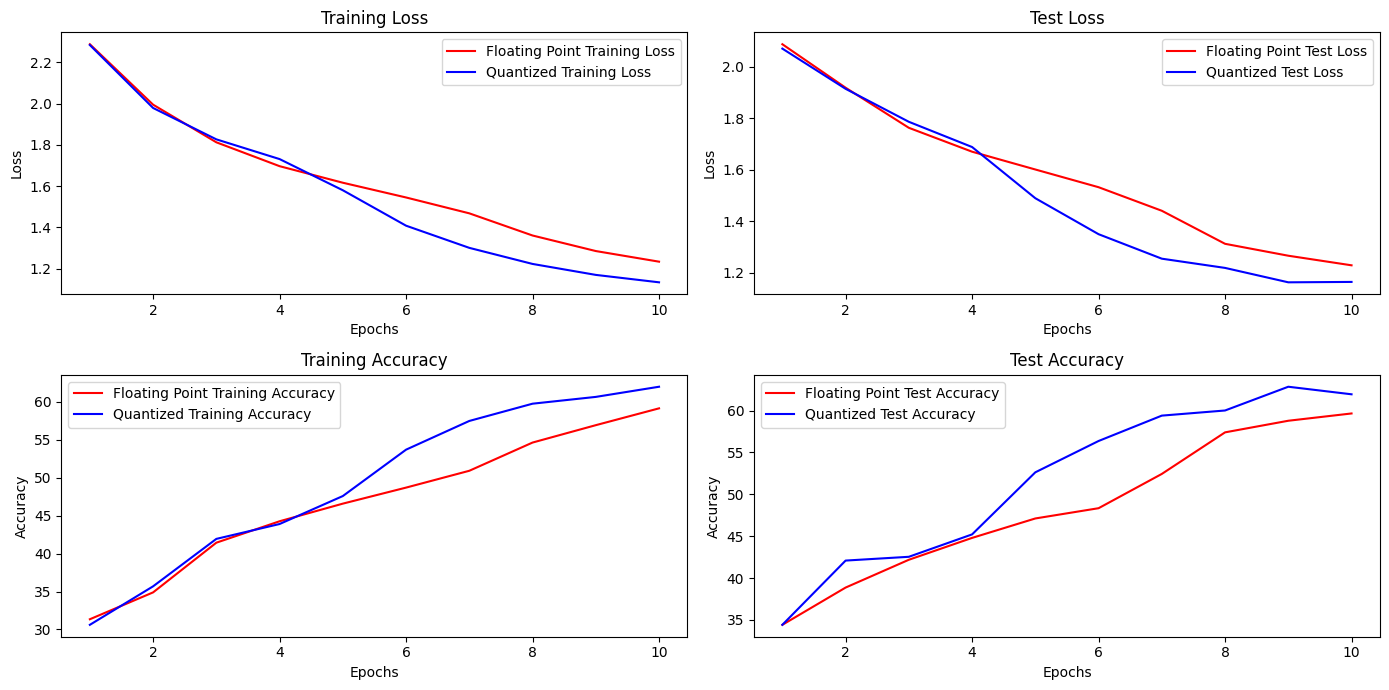

In [28]:
epochs = range(1, len(train_accs) + 1)

plt.figure(figsize=(14, 7))

# Plotting Training Loss
plt.subplot(2, 2, 1)
plt.plot(epochs, train_losses, 'r', label='Floating Point Training Loss')
plt.plot(epochs, qtrain_losses, 'b', label='Quantized Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting Test Loss
plt.subplot(2, 2, 2)
plt.plot(epochs, test_losses, 'r', label='Floating Point Test Loss')
plt.plot(epochs, qtest_losses, 'b', label='Quantized Test Loss')
plt.title('Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting Training Accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs, train_accs, 'r', label='Floating Point Training Accuracy')
plt.plot(epochs, qtrain_accs, 'b', label='Quantized Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting Test Accuracy
plt.subplot(2, 2, 4)
plt.plot(epochs, test_accs, 'r', label='Floating Point Test Accuracy')
plt.plot(epochs, qtest_accs, 'b', label='Quantized Test Accuracy')
plt.title('Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Let's have a look at how quantization works

In [29]:
first_conv = qwac_net.conv1

In [30]:
quant_w = first_conv.quant_weight()
print(quant_w)

QuantTensor(value=tensor([[[[-0.0296,  0.1292,  0.0753, -0.0242,  0.0807],
          [-0.0457, -0.0135, -0.0511, -0.0242, -0.0269],
          [-0.0161, -0.0565,  0.0700,  0.0619, -0.0269],
          [ 0.1184,  0.0457,  0.1022,  0.0996, -0.0296],
          [-0.0296,  0.1534,  0.1507, -0.0188,  0.0350]],

         [[ 0.1103,  0.0888,  0.0861,  0.0215,  0.0888],
          [ 0.1157, -0.0215,  0.0888,  0.0619,  0.0188],
          [ 0.0484,  0.0700,  0.1265,  0.0215,  0.0942],
          [-0.0242,  0.1345,  0.1157,  0.1184,  0.0161],
          [ 0.1480,  0.0538,  0.1588, -0.0834, -0.0027]],

         [[ 0.1749,  0.0350, -0.0538,  0.1049, -0.0807],
          [ 0.0269,  0.0269,  0.0135,  0.0511,  0.0269],
          [ 0.1238,  0.1399, -0.0269, -0.0323, -0.0619],
          [-0.0511,  0.0511,  0.0431,  0.0996, -0.0296],
          [ 0.0780,  0.0753,  0.0242, -0.0726, -0.0646]]],


        [[[-0.0538, -0.0296,  0.0323,  0.1049, -0.0673],
          [-0.1345,  0.0377,  0.0242,  0.0323, -0.0000],
     

In [31]:
int_weight = first_conv.int_weight()
print(int_weight)

tensor([[[[ -11,   48,   28,   -9,   30],
          [ -17,   -5,  -19,   -9,  -10],
          [  -6,  -21,   26,   23,  -10],
          [  44,   17,   38,   37,  -11],
          [ -11,   57,   56,   -7,   13]],

         [[  41,   33,   32,    8,   33],
          [  43,   -8,   33,   23,    7],
          [  18,   26,   47,    8,   35],
          [  -9,   50,   43,   44,    6],
          [  55,   20,   59,  -31,   -1]],

         [[  65,   13,  -20,   39,  -30],
          [  10,   10,    5,   19,   10],
          [  46,   52,  -10,  -12,  -23],
          [ -19,   19,   16,   37,  -11],
          [  29,   28,    9,  -27,  -24]]],


        [[[ -20,  -11,   12,   39,  -25],
          [ -50,   14,    9,   12,    0],
          [ -31,   17,   10,   -6,  -28],
          [ -21,   12,   10,   26,    3],
          [ -42,  -42,    3,   -7,  -38]],

         [[ -55,   -4,   31,   16,  -39],
          [ -18,   -4,   -9,   -8,  -12],
          [ -17,   31,   -8,   29,   27],
          [ -43,   34,  

In [32]:
zero_point = first_conv.quant_weight_zero_point()
print(zero_point)

tensor(0.)


In [33]:
scale = first_conv.quant_weight_scale()
print(scale)

tensor(0.0027, grad_fn=<DivBackward0>)


In [34]:
quant_weight_manually = (int_weight - zero_point) * scale
print(quant_weight_manually)

tensor([[[[-0.0296,  0.1292,  0.0753, -0.0242,  0.0807],
          [-0.0457, -0.0135, -0.0511, -0.0242, -0.0269],
          [-0.0161, -0.0565,  0.0700,  0.0619, -0.0269],
          [ 0.1184,  0.0457,  0.1022,  0.0996, -0.0296],
          [-0.0296,  0.1534,  0.1507, -0.0188,  0.0350]],

         [[ 0.1103,  0.0888,  0.0861,  0.0215,  0.0888],
          [ 0.1157, -0.0215,  0.0888,  0.0619,  0.0188],
          [ 0.0484,  0.0700,  0.1265,  0.0215,  0.0942],
          [-0.0242,  0.1345,  0.1157,  0.1184,  0.0161],
          [ 0.1480,  0.0538,  0.1588, -0.0834, -0.0027]],

         [[ 0.1749,  0.0350, -0.0538,  0.1049, -0.0807],
          [ 0.0269,  0.0269,  0.0135,  0.0511,  0.0269],
          [ 0.1238,  0.1399, -0.0269, -0.0323, -0.0619],
          [-0.0511,  0.0511,  0.0431,  0.0996, -0.0296],
          [ 0.0780,  0.0753,  0.0242, -0.0726, -0.0646]]],


        [[[-0.0538, -0.0296,  0.0323,  0.1049, -0.0673],
          [-0.1345,  0.0377,  0.0242,  0.0323,  0.0000],
          [-0.0834,  0.

In [35]:
print(quant_w.value.flatten()[:10])
print(quant_weight_manually.flatten()[:10])

tensor([-0.0296,  0.1292,  0.0753, -0.0242,  0.0807, -0.0457, -0.0135, -0.0511,
        -0.0242, -0.0269], grad_fn=<SliceBackward0>)
tensor([-0.0296,  0.1292,  0.0753, -0.0242,  0.0807, -0.0457, -0.0135, -0.0511,
        -0.0242, -0.0269], grad_fn=<SliceBackward0>)
